In [1]:
import os
import numpy as np
from tqdm import tqdm

# Modify Caption Data

In [1]:
import json

In [6]:
with open('data/coco/captions_train2017.json') as f:
    b = json.loads(f.read())

with open('data/coco/train_detectron1.json') as f:
    detect = json.loads(f.read())

In [4]:
b.keys()

dict_keys(['info', 'licenses', 'images', 'annotations'])

In [7]:
b['images'][0]

{'license': 3,
 'file_name': '000000391895.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-14 11:18:45',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'id': 391895}

In [8]:
b['annotations'][0]

{'image_id': 203564,
 'id': 37,
 'caption': 'A bicycle replica with a clock as the front wheel.'}

In [58]:
img_id_to_name = dict()
img_id_to_box = {}

for image in b['images']:
    if image['file_name'] in detect:
        img_id_to_name[image['id']] = detect[image['file_name']]['name']
        img_id_to_box[image['id']] = detect[image['file_name']]['box']
        out['images'].append(image)

In [39]:
for annotation in b['annotations']:
    if annotation['image_id'] in img_id_to_name:
        annotation['caption'] = annotation['caption'].replace(img_id_to_name[annotation['image_id']], 'zzzzzzzz')
        out['annotations'].append(annotation)

In [37]:
out = {'info' : b['info'], 'licenses' : b['licenses'], 'images' : [], 'annotations' : []}

In [42]:
len(out['annotations']) / len(out['images'])

5.002805856325767

In [43]:
with open('data/coco/expt.json', 'w') as f:
    f.write(json.dumps(out))

In [23]:
import nltk

In [26]:
nltk.tokenize.word_tokenize('I have a @@MASK@@', language='english')


['I', 'have', 'a', '@', '@', 'MASK', '@', '@']

# Modify Image Features

In [1]:
import h5py

In [2]:
hf = h5py.File('data/coco_train2017_vg_detector_features_adaptive.h5', 'r+')

In [90]:
list(hf.keys())

['boxes', 'features', 'height', 'image_id', 'num_boxes', 'width']

In [ ]:
tmp = hf['boxes'][0].copy()
hf['boxes'][0] = np.array([12,3,4])
hf['boxes'][0]

In [15]:
a = [3,5]
import copy
tmp = hf['width'][a]
del hf['width']
hf.create_dataset('width', data=tmp)
hf['width']

<HDF5 dataset "width": shape (2,), type "<f4">

In [18]:
hf['width'][1]

640.0

In [111]:
avg_boxes_before, avg_boxes_after = 0, 0
keep_inds = []

for i, image_id in enumerate(tqdm(hf['image_id'])):
    if image_id not in img_id_to_box:
        continue

    keep_inds.append(i)

    num_boxes = hf['num_boxes'][i]
    # easier to create a larger thing then trim down, compared to append (not in-place for numpy)
    new_boxes, new_features = np.zeros(num_boxes * 4), np.zeros(num_boxes * 2048)
    new_count = 0

    for j in range(num_boxes):
        if iou(hf['boxes'][i][j*4:j*4+4], img_id_to_box[image_id]) < 1/3:
            new_boxes[new_count*4:new_count*4+4] = hf['boxes'][i][j*4:j*4+4]
            new_features[new_count*2048:new_count*2048+2048] = hf['features'][i][j*2048:j*2048+2048]
            new_count += 1

    hf['boxes'][i] = new_boxes[:4*new_count]
    hf['features'][i] = new_features[:2048*new_count]

    avg_boxes_before += num_boxes
    avg_boxes_after += new_count

  0%|          | 0/118287 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
for key in hf.keys():
    hf[key] = hf[key][keep_inds]

print('Average # boxes before: ', avg_boxes_before / len(hf['num_boxes']))
print('Average # boxes after: ', avg_boxes_after / len(hf['num_boxes']))

In [8]:
import copy
copy.copy(hf['num_boxes'])[]

<HDF5 dataset "num_boxes": shape (118287,), type "<i8">

In [19]:
hf.close()

In [67]:
# method adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    bounding box format (x1, y1, x2, y2), x1 < x2, y1 < y2

    Returns
    -------
    float
        in [0, 1]
    """
    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    x_right = min(bb1[2], bb2[2])
    y_top = max(bb1[1], bb2[1])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    return iou

# Detectron (use pytorch_p38)

In [2]:
import torch, torchvision

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
with open('data/coco_classnames.txt') as f:
    import ast
    coco_labels = ast.literal_eval(f.read())

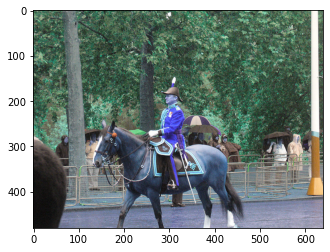

In [4]:
im = cv2.imread('data/000000439715.jpg')

plt.imshow(im)
plt.show()

In [5]:
cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [ ]:
img_to_boxes = dict()

In [6]:
outputs = predictor(im)

/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272172048/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
ind = torch.nonzero(outputs['instances'].pred_classes)[0].item()
ind

0

In [19]:
outputs['instances'].pred_boxes[0].tensor.numpy().tolist()[0]

[126.60348510742188, 244.89768981933594, 459.8291015625, 480.0]

In [22]:
coco_labels[outputs['instances'].pred_classes[ind].item()+1]

'horse'

In [25]:
import os

a = os.listdir('data/coco/train2017')
type(a)

list

In [22]:
a = torch.tensor([0,1,2,3])
torch.mul((a > 0).long(), a - 1) 

tensor([ 0,  0,  1, 16])

# Misc Workspace

In [1]:
b = {i : 'lol' for i in range(30)}
with open('data/nocaps/nocaps_val_names.txt', 'w') as f:
    print(b, file=f)

In [20]:
import torch

In [2]:
import json
import numpy as np
from tqdm import tqdm
import h5py


In [3]:
hf = h5py.File('data/coco_train2017_vg_detector_features_adaptive.h5', 'r+')

In [4]:
with open('data/coco/captions_train2017.json') as f:
    b = json.loads(f.read())

with open('data/coco/train_detectron1.json') as f:
    detect = json.loads(f.read())

out = {'info' : b['info'], 'licenses' : b['licenses'], 'images' : [], 'annotations' : []}
img_id_to_name = {}
img_id_to_box = {}

for image in b['images']:
    if image['file_name'] in detect:
        img_id_to_name[image['id']] = detect[image['file_name']]['name']
        img_id_to_box[image['id']] = detect[image['file_name']]['box']
        out['images'].append(image)

for annotation in b['annotations']:
    if annotation['image_id'] in img_id_to_name:
        annotation['caption'] = annotation['caption'].replace(img_id_to_name[annotation['image_id']], 'zzzzzzzz')
        out['annotations'].append(annotation)

with open('data/coco/expt.json', 'w') as f:
    f.write(json.dumps(out))

# method adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    bounding box format (x1, y1, x2, y2), x1 < x2, y1 < y2

    Returns
    -------
    float
        in [0, 1]
    """
    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    x_right = min(bb1[2], bb2[2])
    y_top = max(bb1[1], bb2[1])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    return iou

avg_boxes_before, avg_boxes_after = 0, 0
keep_inds = []

for i, image_id in enumerate(tqdm(hf['image_id'])):
    if image_id not in img_id_to_box:
        continue

    keep_inds.append(i)

    num_boxes = hf['num_boxes'][i]
    # easier to create a larger thing then trim down, compared to append (not in-place for numpy)
    new_boxes, new_features = np.zeros(num_boxes * 4), np.zeros(num_boxes * 2048)
    new_count = 0

    for j in range(num_boxes):
        if iou(hf['boxes'][i][j*4:j*4+4], img_id_to_box[image_id]) < 1/3:
            new_boxes[new_count*4:new_count*4+4] = hf['boxes'][i][j*4:j*4+4]
            new_features[new_count*2048:new_count*2048+2048] = hf['features'][i][j*2048:j*2048+2048]
            new_count += 1

    hf['boxes'][i] = new_boxes[:4*new_count]
    hf['features'][i] = new_features[:2048*new_count]

    if len(keep_inds) == 10:
        break

    avg_boxes_before += num_boxes
    avg_boxes_after += new_count

    if len(keep_inds) == 10:
        break

  0%|          | 31/118287 [00:00<17:40, 111.54it/s]


In [5]:
keep_inds

[0, 2, 3, 9, 15, 18, 22, 29, 30, 31]

In [6]:
for key in hf.keys():
    tmp = hf[key][keep_inds]
    del hf[key]
    hf.create_dataset(key, data=tmp)

In [8]:
hf.close()

# Download Val Images

In [15]:
import json
from tqdm import tqdm
# import requests
import os

with open('/home/ubuntu/updown-baseline/data/nocaps/nocaps_val_image_info.json') as f:
    val = json.loads(f.read())

os.chdir('/home/ubuntu/updown-baseline/data/nocaps/val')

In [16]:
for image in tqdm(val['images']):
    os.system(f"wget {image['coco_url']}")
    # response = requests.get(image['coco_url'])
    # open(f"data/nocaps/val/{image['file_name']}", "wb").write(response.content)

100%|██████████| 4500/4500 [13:27<00:00,  5.58it/s]


In [7]:
len(val['images'])

4500

In [12]:
os.chdir('/home/ubuntu/updown-baseline')

with open('data/nocaps/nocaps_test_image_info.json') as f:
    test = json.loads(f.read())

os.chdir('data/nocaps/val')

for image in tqdm(test['images']):
    os.system(f"wget {image['coco_url']}")
    # response = requests.get(image['coco_url'])
    # open(f"data/nocaps/val/{image['file_name']}", "wb").write(response.content)

100%|██████████| 10600/10600 [33:49<00:00,  5.22it/s]


In [13]:
os.chdir('/home/ubuntu/updown-baseline')
len(os.listdir('data/nocaps/val'))

10596

In [17]:
os.getcwd()

'/home/ubuntu/updown-baseline/data/nocaps/val'

In [19]:
with open('/home/ubuntu/updown-baseline/data/nocaps/val_detectron.json') as f:
    contents = json.loads(f.read())

In [21]:
len(contents.keys())

4237

In [35]:
import json
import numpy as np
from tqdm import tqdm
import h5py

with open('/home/ubuntu/updown-baseline/data/nocaps/nocaps_val_image_info.json') as f:
    b = json.loads(f.read())

with open('/home/ubuntu/updown-baseline/data/nocaps/val_detectron.json') as f:
    detect = json.loads(f.read())

img_id_to_box = {}
out = {}

for image in b['images']:
    if image['file_name'] in detect:
        img_id_to_box[image['id']] = detect[image['file_name']]['box']
        out[image['id']] =  detect[image['file_name']]['name']

with open('/home/ubuntu/updown-baseline/data/nocaps/nocaps_val_names.txt', 'w') as f:
    print(out, file=f)

In [5]:
import h5py
from tqdm import tqdm

hf = h5py.File('/home/ubuntu/updown-baseline/data/coco_train2017_vg_detector_features_adaptive.h5', 'r+')

In [6]:
for i in tqdm(range(len(hf['image_id']))):
    assert len(hf['boxes'][i]) * 512 == len(hf['features'][i])
    hf['num_boxes'][i] = len(hf['boxes'][i]) // 4

hf.close()

100%|██████████| 29361/29361 [01:00<00:00, 485.49it/s]


In [9]:
a = [1,2,3,4,5]
b = [num for num in a if num % 2 == 0 else num + 1 if num < 4 else 0]

SyntaxError: invalid syntax (<ipython-input-9-1a1a69ec6f06>, line 2)

In [17]:
a = '''-rw-------  1 ubuntu ubuntu 315415 Apr 28 06:57 tmp0dp63sju.json
-rw-------  1 ubuntu ubuntu 317622 Apr 28 07:44 tmp10ozi7kz.json
-rw-------  1 ubuntu ubuntu 310501 Apr 28 07:59 tmp1_av6ept.json
-rw-------  1 ubuntu ubuntu 322400 Apr 28 13:08 tmp1_wz3lp8.json
-rw-------  1 ubuntu ubuntu 313937 Apr 28 09:01 tmp1wv2m4pu.json
-rw-------  1 ubuntu ubuntu 313683 Apr 28 08:30 tmp36w9akc3.json
-rw-------  1 ubuntu ubuntu 314380 Apr 28 08:15 tmp4otcevej.json
-rw-------  1 ubuntu ubuntu 310028 Apr 28 06:26 tmp5m60ko1i.json
-rw-------  1 ubuntu ubuntu 321400 Apr 28 12:53 tmp69n6s4rd.json
-rw-------  1 ubuntu ubuntu 321959 Apr 28 13:52 tmp8853nt94.json
-rw-------  1 ubuntu ubuntu 320946 Apr 28 13:38 tmp9c2dj18l.json
-rw-------  1 ubuntu ubuntu 312435 Apr 28 09:48 tmp_ffpj_ko.json
-rw-------  1 ubuntu ubuntu 315792 Apr 28 10:51 tmp_r155ms3.json
-rw-------  1 ubuntu ubuntu 320914 Apr 28 13:23 tmp_x6lpc4v.json
-rw-------  1 ubuntu ubuntu 317099 Apr 28 07:28 tmpa7j6j2z5.json
-rw-------  1 ubuntu ubuntu 318083 Apr 28 10:35 tmpbednftfb.json
-rw-------  1 ubuntu ubuntu 316549 Apr 28 12:08 tmpbm9o1rt1.json
-rw-------  1 ubuntu ubuntu 320667 Apr 28 11:37 tmpd7tsj0x0.json
-rw-------  1 ubuntu ubuntu 315329 Apr 28 10:04 tmpdczcvlox.json
-rw-------  1 ubuntu ubuntu 301878 Apr 28 05:40 tmpe_xgabwh.json
-rw-------  1 ubuntu ubuntu 316646 Apr 28 08:46 tmpee8zwkaw.json
-rw-------  1 ubuntu ubuntu 314378 Apr 28 06:41 tmpeq_ak4u3.json
-rw-------  1 ubuntu ubuntu 311431 Apr 28 06:10 tmpfq8gxzyr.json
-rw-------  1 ubuntu ubuntu 322101 Apr 28 11:53 tmpiqp7c229.json
-rw-------  1 ubuntu ubuntu 319619 Apr 28 09:18 tmpmp2ux075.json
-rw-------  1 ubuntu ubuntu 322361 Apr 28 14:22 tmpo2s7x3dp.json
-rw-------  1 ubuntu ubuntu 319876 Apr 28 11:22 tmpqhmp9eis.json
-rw-------  1 ubuntu ubuntu 310059 Apr 28 05:55 tmpskjxptin.json
-rw-------  1 ubuntu ubuntu 321334 Apr 28 12:23 tmptaek5vxw.json
-rw-------  1 ubuntu ubuntu 322873 Apr 28 14:07 tmptkf1bgtn.json
-rw-------  1 ubuntu ubuntu 314755 Apr 28 07:12 tmpu70kkv1w.json
-rw-------  1 ubuntu ubuntu 319973 Apr 28 12:39 tmpuzmhyba9.json
-rw-------  1 ubuntu ubuntu 316197 Apr 28 10:19 tmpvbkbl3b7.json
-rw-------  1 ubuntu ubuntu 313683 Apr 28 09:33 tmpycwb5pj0.json
-rw-------  1 ubuntu ubuntu 322639 Apr 28 11:06 tmpzfo388p6.json'''.split('\n')

In [21]:
import os

b = [st.split()[7:9] for st in a]
b.sort()

for i, (_, filename) in enumerate(b):
    os.system(f'cp /tmp/{filename} outputs/iter_{(i + 1) * 1000}.json')

In [20]:
os.getcwd()

'/home/ubuntu/updown-baseline'

In [11]:
%tensorboard --logdir checkpoints/updown

In [10]:
%load_ext tensorboard

In [2]:
import json

In [7]:
with open('train_detectron1.json') as f:
    d1 = json.loads(f.read())

with open('train_detectron2.json') as f:
    d2 = json.loads(f.read())

with open('train_detectron3.json') as f:
    d3 = json.loads(f.read())

with open('train_detectron4.json') as f:
    d4 = json.loads(f.read())

d1.update(d2)
d1.update(d3)
d1.update(d4)

In [6]:
a = {1:1,2:2}
b = {3:3}
a.update(b)
a

{1: 1, 2: 2, 3: 3}

In [8]:
len(d1)

117432

In [15]:
with open('train_detectron.json', 'w') as f:
    json.dump(d1, fp=f)

In [7]:
import json

with open('data/coco/captions_train2017_mod.json') as f:
    dic = json.loads(f.read())

len(dic['images'])

118287

In [16]:
# average: 5 captions per image
# 2 captions per image contains detected object name (and was replaced by zzzzzzzz)

import json
import numpy as np
from tqdm import tqdm
import h5py

with open('data/coco/captions_train2017.json') as f:
    b = json.loads(f.read())

with open('data/coco/train_detectron.json') as f:
    detect = json.loads(f.read())

out = {'info' : b['info'], 'licenses' : b['licenses'], 'images' : [], 'annotations' : []}
img_id_to_name = {}
img_id_to_box = {}

for image in b['images']:
    if image['file_name'] in detect:
        img_id_to_name[image['id']] = detect[image['file_name']]['name']
        img_id_to_box[image['id']] = detect[image['file_name']]['box']
        out['images'].append(image)

count = 0
for annotation in b['annotations']:
    if annotation['image_id'] in img_id_to_name:
        annotation['caption'] = annotation['caption'].replace(img_id_to_name[annotation['image_id']], 'zzzzzzzz')
        out['annotations'].append(annotation)
        if 'zzzzzzzz' in annotation['caption']:
            count += 1

with open('data/coco/captions_train2017_mod.json', 'w') as f:
    f.write(json.dumps(out))

print(f'Average captions per image: {len(out["annotations"]) / len(out["images"]):.2f}')
print(f'Average captions modified per image: {count / len(out["images"]):.2f}')
print()

Average captions per image: 5.00
Average captions modified per image: 2.00



In [1]:
import numpy as np

In [8]:
a = np.array([[[0,1,2], [3,4,5], [6,7,8]]])
np.delete(a, [1,2], axis=1)

array([[[0, 1, 2]]])

In [9]:
import json
import numpy as np
from tqdm import tqdm
import h5py

with open('data/coco/captions_train2017.json') as f:
    b = json.loads(f.read())

with open('data/coco/train_detectron.json') as f:
    detect = json.loads(f.read())

out = {'info' : b['info'], 'licenses' : b['licenses'], 'images' : [], 'annotations' : []}
img_id_to_name = {}
img_id_to_box = {}

for image in b['images']:
    if image['file_name'] in detect:
        img_id_to_name[image['id']] = detect[image['file_name']]['name']
        img_id_to_box[image['id']] = detect[image['file_name']]['box']
    out['images'].append(image)

count = 0
for annotation in b['annotations']:
    if annotation['image_id'] in img_id_to_name:
        annotation['caption'] = annotation['caption'].replace(img_id_to_name[annotation['image_id']], 'zzzzzzzz')
    out['annotations'].append(annotation)
    if 'zzzzzzzz' in annotation['caption']:
        count += 1

with open('data/coco/captions_train2017_mod.json', 'w') as f:
    f.write(json.dumps(out))

# Average captions per image: 5.00
# Average captions modified per image: 1.98
# 117432
print(f'Average captions per image: {len(out["annotations"]) / len(out["images"]):.4f}')
print(f'Average captions modified per image: {count / len(img_id_to_name):.4f}')
print()

Average captions per image: 5.0027
Average captions modified per image: 1.9987



# Demo

In [3]:
DATA_PATH = 'train2017'
OUT = 'train_detectron1.json'

import torch, torchvision

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
from tqdm import tqdm
import json
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

cfg = get_cfg()
# cfg.MODEL.DEVICE='cpu'
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

with open('data/coco_classnames.txt') as f:
    import ast
    coco_labels = ast.literal_eval(f.read())


In [4]:
with open('data/coco/captions_train2017.json') as f:
    captions = json.loads(f.read())

--2022-04-30 21:49:02--  http://images.cocodataset.org/train2017/000000271999.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.248.164
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.248.164|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199729 (195K) [image/jpeg]
Saving to: ‘000000271999.jpg’

     0K .......... .......... .......... .......... .......... 25% 2.14M 0s
    50K .......... .......... .......... .......... .......... 51% 4.21M 0s
   100K .......... .......... .......... .......... .......... 76% 4.17M 0s
   150K .......... .......... .......... .......... .....     100% 3.85M=0.06s

2022-04-30 21:49:03 (3.31 MB/s) - ‘000000271999.jpg’ saved [199729/199729]



A locomotive with two passenger cars waits at a train station.
A passenger train view from an adjacent station.
A train pulling into a train station while it's raining.
A train pulling in to a nearby train station
On an overcast day a red train sits at the train station.

Object: train
Bounding box: [169.1984405517578, 227.15150451660156, 483.24420166015625, 316.9194030761719]
Confidence: 0.9964557

Object: train
Bounding box: [53.44200897216797, 245.7313690185547, 58.09331512451172, 257.9851379394531]
Confidence: 0.87668574



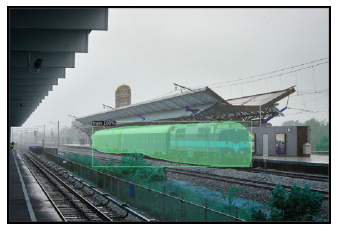

In [34]:
choice = random.choice(captions['images'])
os.system(f'wget {choice["coco_url"]}')

for annotation in captions['annotations']:
    if annotation['image_id'] == choice['id']:
        print(annotation['caption'])
print()

im = cv2.imread(choice['file_name'])
plt.axis('off')
plt.imshow(im[:,:,::-1])

os.system(f'rm {choice["file_name"]}')
outputs = predictor(im)

for i in range(min(5, len(outputs['instances'].pred_boxes))):
    print('Object:', coco_labels[outputs['instances'].pred_classes[0].item()+1])
    print('Bounding box:', outputs['instances'].pred_boxes[i].tensor.cpu().numpy().tolist()[0])
    print('Confidence:', outputs['instances'].scores[i].cpu().numpy())
    print()

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"][0].to("cpu"))
plt.axis('off')
plt.imshow(out.get_image()[:, :, ::-1])
plt.savefig('example3.png')

In [20]:
for i in range(5):
    print('Object:', coco_labels[outputs['instances'].pred_classes[0].item()+1])
    print('Bounding box:', outputs['instances'].pred_boxes[i].tensor.cpu().numpy().tolist()[0])
    print('Confidence:', outputs['instances'].scores[i].cpu().numpy())
    print()

Object: person
Bounding box: [0.030968379229307175, 81.90483093261719, 58.768287658691406, 382.6935119628906]
Confidence: 0.99352056

Object: person
Bounding box: [492.9728088378906, 185.04812622070312, 639.2283935546875, 356.7805480957031]
Confidence: 0.9934011

Object: person
Bounding box: [204.2906951904297, 205.3551483154297, 259.6820983886719, 281.6136779785156]
Confidence: 0.9881904

Object: person
Bounding box: [275.4656982421875, 211.43907165527344, 304.8517761230469, 251.323974609375]
Confidence: 0.98174137

Object: person
Bounding box: [387.53369140625, 197.28106689453125, 425.9681701660156, 255.57774353027344]
Confidence: 0.9789641



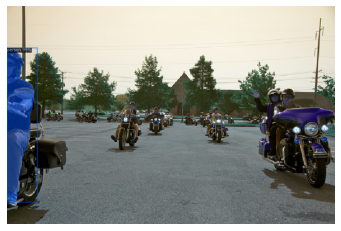

In [23]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"][0].to("cpu"))
plt.axis('off')
plt.imshow(out.get_image()[:, :, ::-1])

In [35]:
os.system(f'wget {choice["coco_url"]}')

--2022-04-30 21:52:00--  http://images.cocodataset.org/train2017/000000271999.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.36.177
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.36.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199729 (195K) [image/jpeg]
Saving to: ‘000000271999.jpg’

     0K .......... .......... .......... .......... .......... 25% 2.24M 0s
    50K .......... .......... .......... .......... .......... 51% 4.43M 0s
   100K .......... .......... .......... .......... .......... 76% 4.31M 0s
   150K .......... .......... .......... .......... .....     100% 4.13M=0.05s

2022-04-30 21:52:00 (3.48 MB/s) - ‘000000271999.jpg’ saved [199729/199729]



0